In [1]:
import os
import sys

from itertools import product

sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt

from utils.dataset import train_test_load
from utils.checkpoint import save_params

from model.train.recommender import training_loop
from model.train.recommender_feature import training_loop as training_loop_feat

In [2]:
test_split = 0.2

train, test = train_test_load("../data/ml-32m/ratings.csv", "../data/ml-32m/movies.csv", test_split=test_split)

### Training

#### Hyperparameter Grid Search

In [3]:
records = []

lambdas = [0.01, 0.1, 0.5]
gammas  = [0.01, 0.1, 0.5]
taus    = [0.01, 0.1, 0.5]

for lmb, tau, gam in product(lambdas, taus, gammas):
    hyper_params = {
        'embedding_dim': 1,
        'r_lambda': lmb,
        'r_gamma': tau,
        'r_tau': gam,
    }

    train_loss, train_rmse, test_loss, test_rmse, _, _, _, _ = training_loop(
        train.user_movies, train.movie_users, test.user_movies, test.movie_users,
        n_iter = 20, **hyper_params
    )
        
    records.append((hyper_params, train_rmse[-1]))

In [22]:
print("Grid Search result")
for hyper_param, loss in records:
    print(f"Hyperparameter: {hyper_param} - Train loss: {loss}")

best_hyper_params, loss = min(records, key=lambda x: x[1])

del best_hyper_params["embedding_dim"]
print(f"Best Hyperparameter: {best_hyper_params} - Train loss: {loss}")

Grid Search result
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.01, 'r_tau': 0.01} - Train loss: 0.8074997663316453
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.01, 'r_tau': 0.1} - Train loss: 0.8099166114905306
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.01, 'r_tau': 0.5} - Train loss: 0.8174051613229903
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.1, 'r_tau': 0.01} - Train loss: 0.8369405576643061
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.1, 'r_tau': 0.1} - Train loss: 0.8427992592358579
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.1, 'r_tau': 0.5} - Train loss: 0.8478348106732442
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.5, 'r_tau': 0.01} - Train loss: 0.8500230469865241
Hyperparameter: {'embedding_dim': 1, 'r_lambda': 0.01, 'r_gamma': 0.5, 'r_tau': 0.1} - Train loss: 0.8664587858741523
Hyperparameter: {'embedding_dim

In [4]:
best_hyper_params = {'r_lambda': 0.5, 'r_gamma': 0.01, 'r_tau': 0.01}

#### Bias Only Model

In [23]:
hyper_params = {'embedding_dim': 0, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [24]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 4590990.924638869
Test Loss: 1186743.437441145
Train RMSE: 0.8457201758289661
Test RMSE: 0.8561877839184345


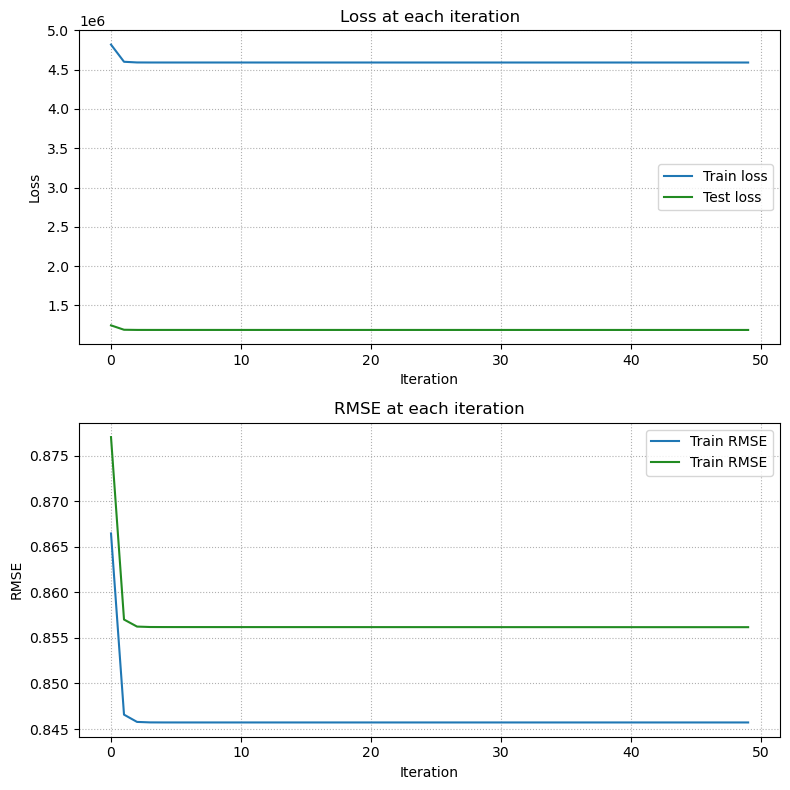

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_bias_only.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [26]:
save_params(
    "../artifacts/model/32m_users_training_bias_only", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

#### 2d Embedding Model

In [27]:
hyper_params = {'embedding_dim': 2, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [28]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 3961527.2607331793
Test Loss: 1083489.4425624323
Train RMSE: 0.7851917399576458
Test RMSE: 0.8167626249336785


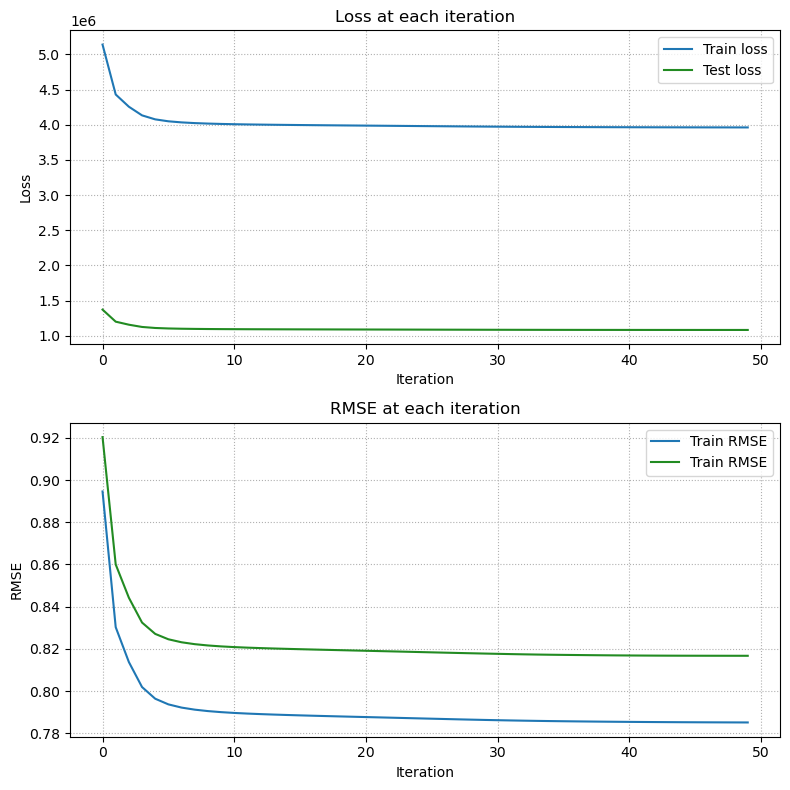

In [29]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_2.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [30]:
save_params(
    "../artifacts/model/32m_users_training_2", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

#### Embedding Dimension Search

In [29]:
embeddings = [0, 2, 4, 8, 10, 16, 20, 32]
results_train_rmse = []
results_train_loss = []
results_test_rmse = []
results_test_loss = []

for e in embeddings:
    hyper_params = {'embedding_dim': e, **best_hyper_params}

    train_loss, train_rmse, test_loss, test_rmse, _, _, _, _ = training_loop(
        train.user_movies, train.movie_users, test.user_movies, test.movie_users,
        n_iter = 50, **hyper_params
    )

    results_train_rmse.append(train_rmse[-1])
    results_train_loss.append(train_loss[-1])
    results_test_rmse.append(test_rmse[-1])
    results_test_loss.append(test_loss[-1])

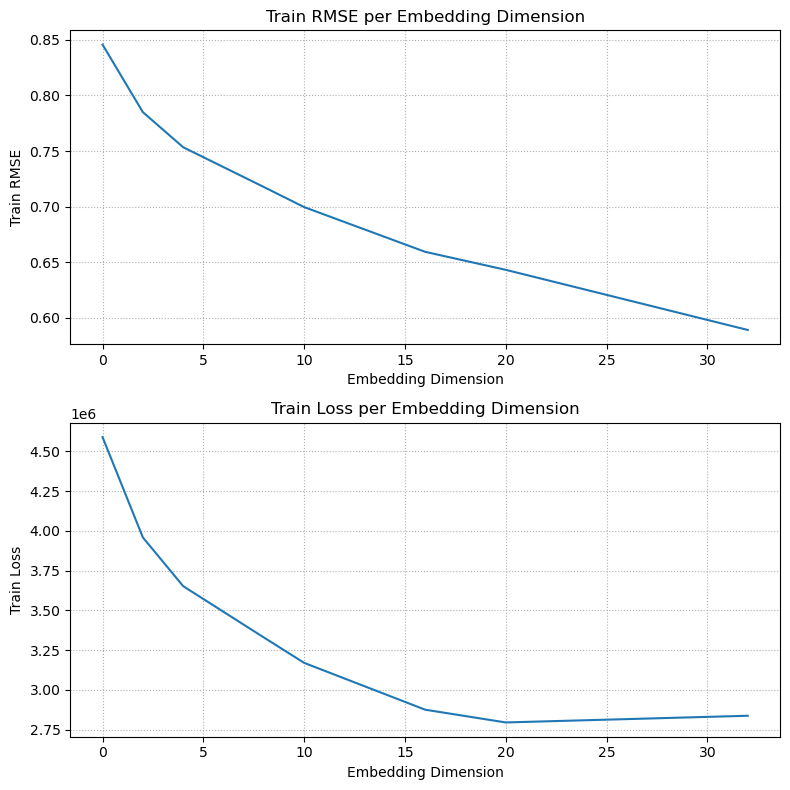

In [30]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(embeddings, results_train_rmse)
axs[0].set_xlabel("Embedding Dimension")
axs[0].set_ylabel("Train RMSE")
axs[0].set_title("Train RMSE per Embedding Dimension")
axs[0].grid(True, linestyle=":")

axs[1].plot(embeddings, results_train_loss)
axs[1].set_xlabel("Embedding Dimension")
axs[1].set_ylabel("Train Loss")
axs[1].set_title("Train Loss per Embedding Dimension")
axs[1].grid(True, linestyle=":")

plt.tight_layout()
plt.savefig("../artifacts/plot/embedding_search.pdf", format="pdf", bbox_inches='tight')
plt.show()

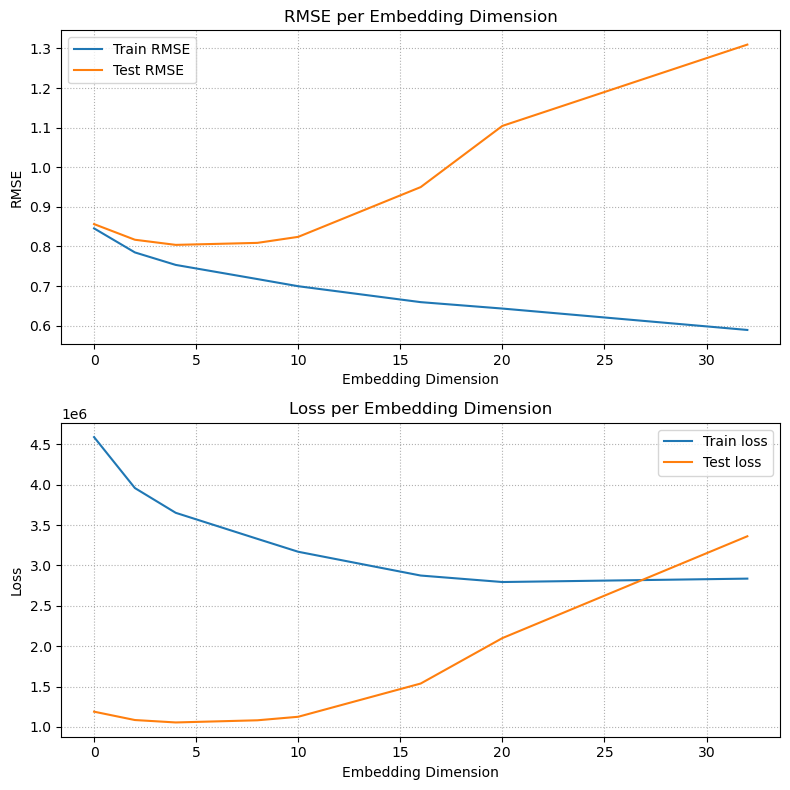

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(embeddings, results_train_rmse, label="Train RMSE")
axs[0].plot(embeddings, results_test_rmse, label="Test RMSE")
axs[0].set_xlabel("Embedding Dimension")
axs[0].set_ylabel("RMSE")
axs[0].set_title("RMSE per Embedding Dimension")
axs[0].legend()
axs[0].grid(True, linestyle=":")

axs[1].plot(embeddings, results_train_loss, label="Train loss")
axs[1].plot(embeddings, results_test_loss, label="Test loss")
axs[1].set_xlabel("Embedding Dimension")
axs[1].set_ylabel("Loss")
axs[1].set_title("Loss per Embedding Dimension")
axs[1].legend()
axs[1].grid(True, linestyle=":")

plt.tight_layout()
plt.savefig("../artifacts/plot/embedding_search_alt.pdf", format="pdf", bbox_inches='tight')
plt.show()

#### Best Model Training

In [4]:
hyper_params = {'embedding_dim': 16, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [5]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 2861890.448354222
Test Loss: 1548412.3110797273
Train RMSE: 0.6587980710514414
Test RMSE: 0.9567113151633913


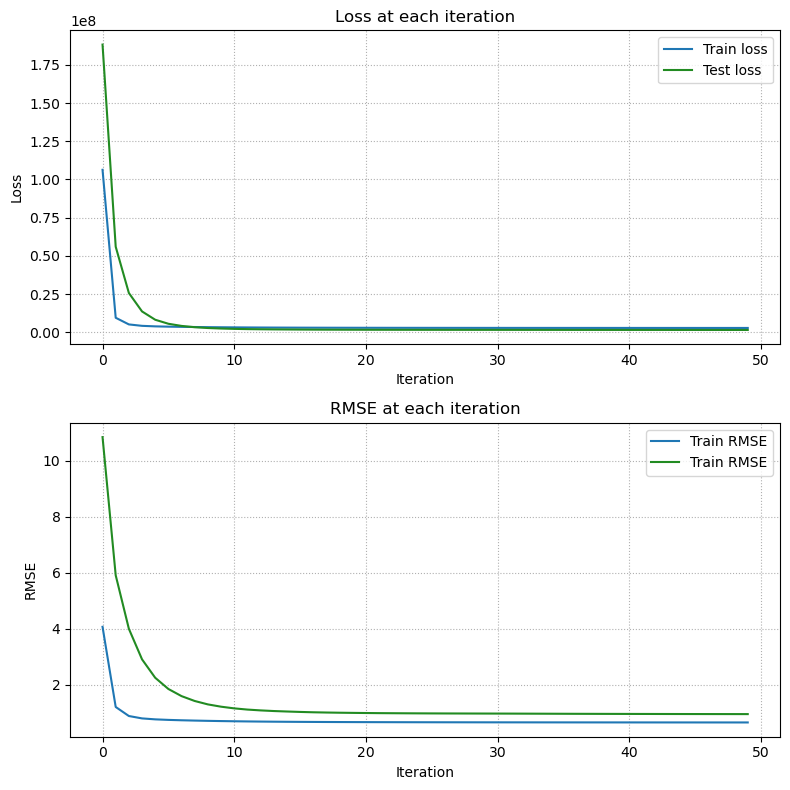

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_16.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [7]:
save_params(
    "../artifacts/model/32m_users_training_16", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

In [5]:
hyper_params = {'embedding_dim': 10, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [6]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 3166912.1065666173
Test Loss: 1130111.8871918009
Train RMSE: 0.6995127244997059
Test RMSE: 0.8266041819533053


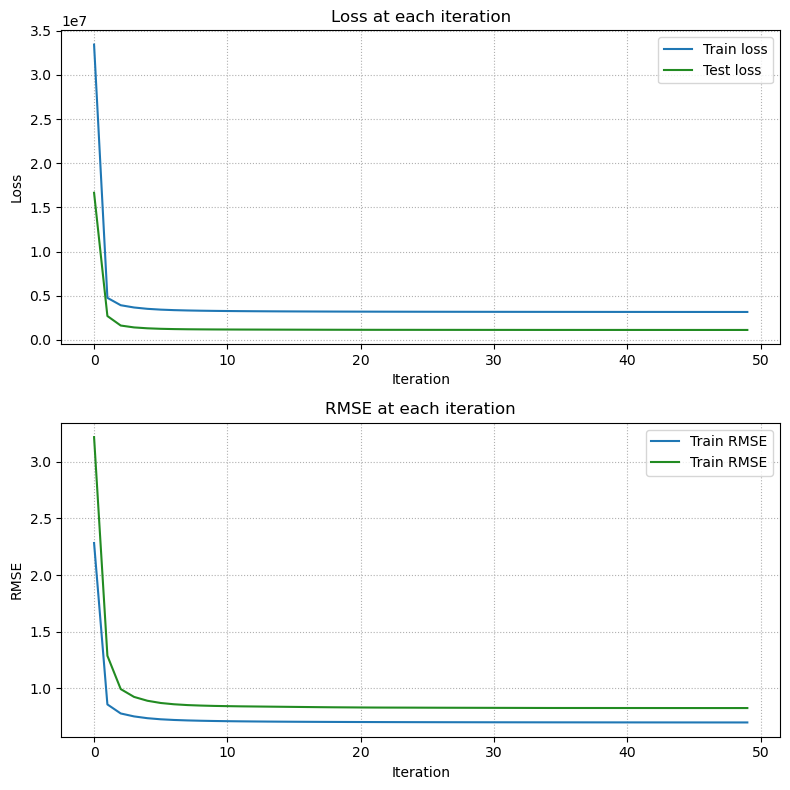

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_10.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [8]:
save_params(
    "../artifacts/model/32m_users_training_10", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

In [14]:
hyper_params = {'embedding_dim': 20, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings = training_loop(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users,
    n_iter = 50, **hyper_params
)

In [15]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 2779789.0716017243
Test Loss: 2041556.8447402099
Train RMSE: 0.6417162974527861
Test RMSE: 1.0890322398466017


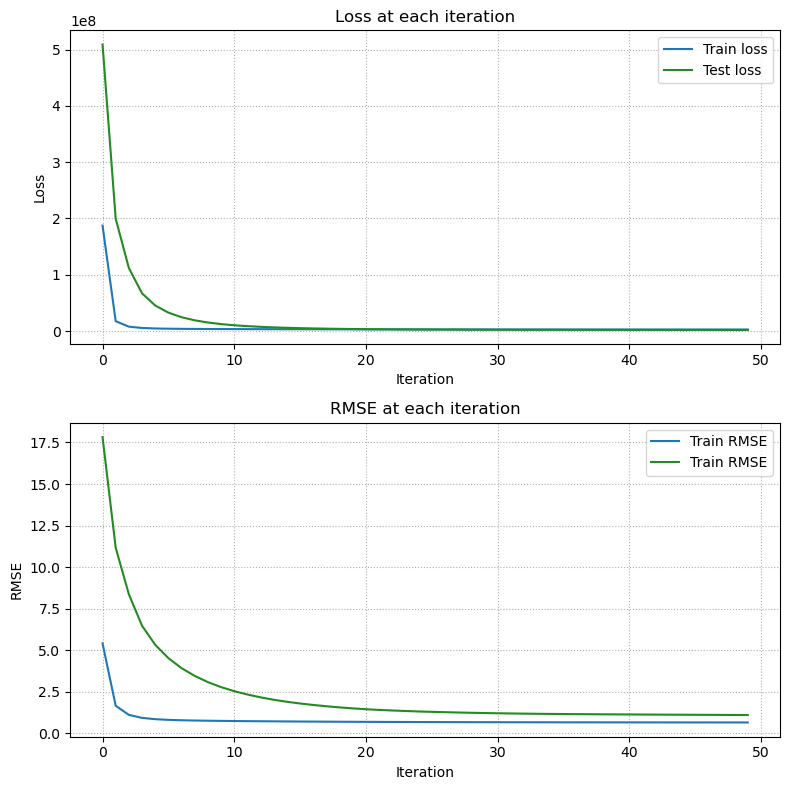

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_20.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [17]:
save_params(
    "../artifacts/model/32m_users_training_20", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
)

#### 2d Features Model

In [8]:
hyper_params = {'embedding_dim': 2, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings, feat_embeddings = training_loop_feat(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users, train.movie_feat, train.feat_movie,
    n_iter = 50, **hyper_params
)

In [9]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 3960522.138382138
Test Loss: 1083573.3689957382
Train RMSE: 0.7850201268952985
Test RMSE: 0.8170040851793144


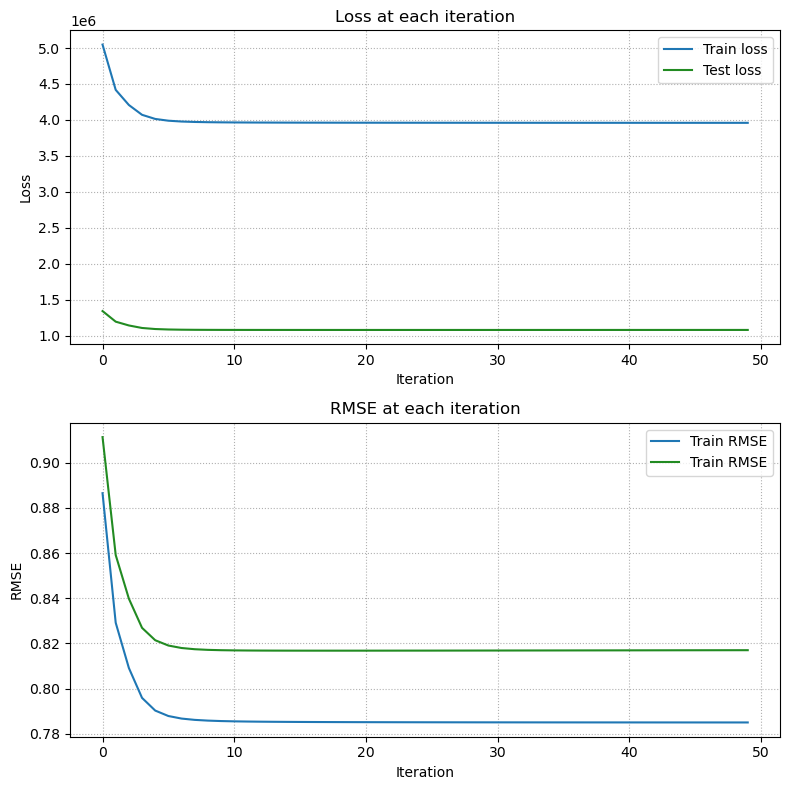

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_with_features_2.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [11]:
save_params(
    "../artifacts/model/32m_users_training_features_2", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
    train.idx_to_feat_id,
    feat_embeddings,
)

#### Model with Features Training

In [9]:
hyper_params = {'embedding_dim': 16, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings, feat_embeddings = training_loop_feat(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users, train.movie_feat, train.feat_movie,
    n_iter = 50, **hyper_params
)

In [10]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 2891502.1978032356
Test Loss: 1622721.9754852902
Train RMSE: 0.6604487377774081
Test RMSE: 0.971886409129242


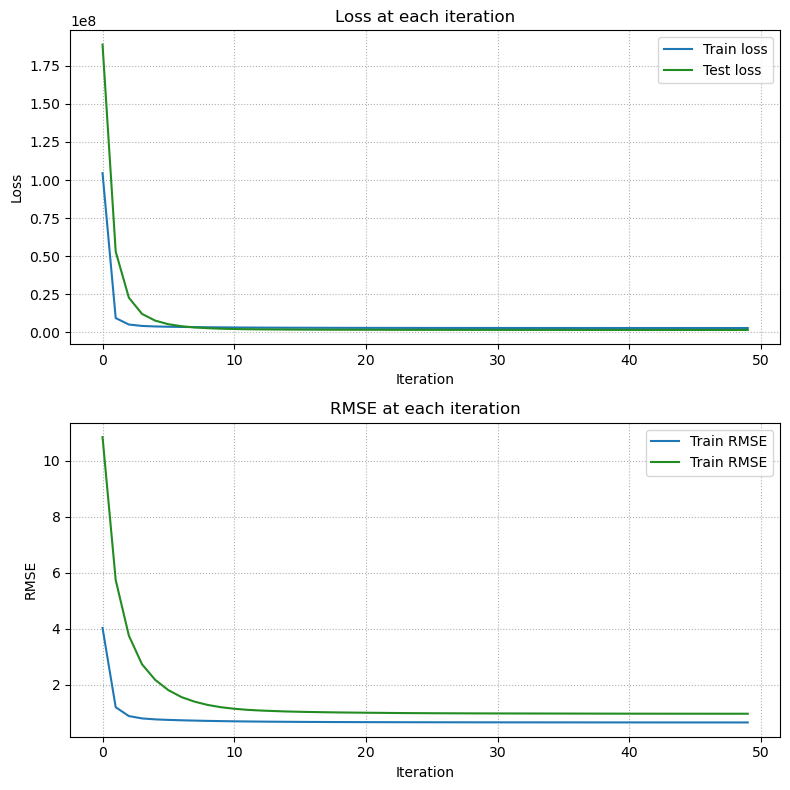

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_with_features_16.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [12]:
save_params(
    "../artifacts/model/32m_users_training_features_16", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
    train.idx_to_feat_id,
    feat_embeddings,
)

In [13]:
hyper_params = {'embedding_dim': 10, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings, feat_embeddings = training_loop_feat(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users, train.movie_feat, train.feat_movie,
    n_iter = 50, **hyper_params
)

In [14]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 3190222.236463893
Test Loss: 1149726.0366685048
Train RMSE: 0.7007523675326565
Test RMSE: 0.8284809093485632


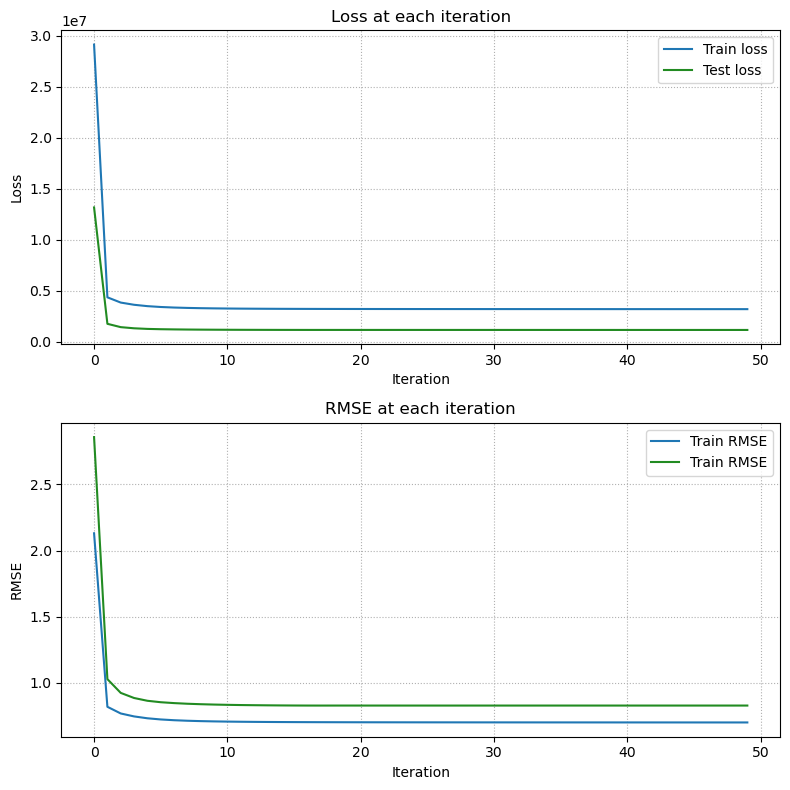

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_with_features_10.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [16]:
save_params(
    "../artifacts/model/32m_users_training_features_10", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
    train.idx_to_feat_id,
    feat_embeddings,
)

In [17]:
hyper_params = {'embedding_dim': 20, **best_hyper_params}

train_loss, train_rmse, test_loss, test_rmse, user_bias, movie_bias, user_embeddings, movie_embeddings, feat_embeddings = training_loop_feat(
    train.user_movies, train.movie_users, test.user_movies, test.movie_users, train.movie_feat, train.feat_movie,
    n_iter = 50, **hyper_params
)

In [18]:
print("## Results ##")
print("Train Loss:", train_loss[-1])
print("Test Loss:", test_loss[-1])
print("Train RMSE:", train_rmse[-1])
print("Test RMSE:", test_rmse[-1])

## Results ##
Train Loss: 2790513.091319086
Test Loss: 2212013.2866866533
Train RMSE: 0.6424046938924453
Test RMSE: 1.1307663052590295


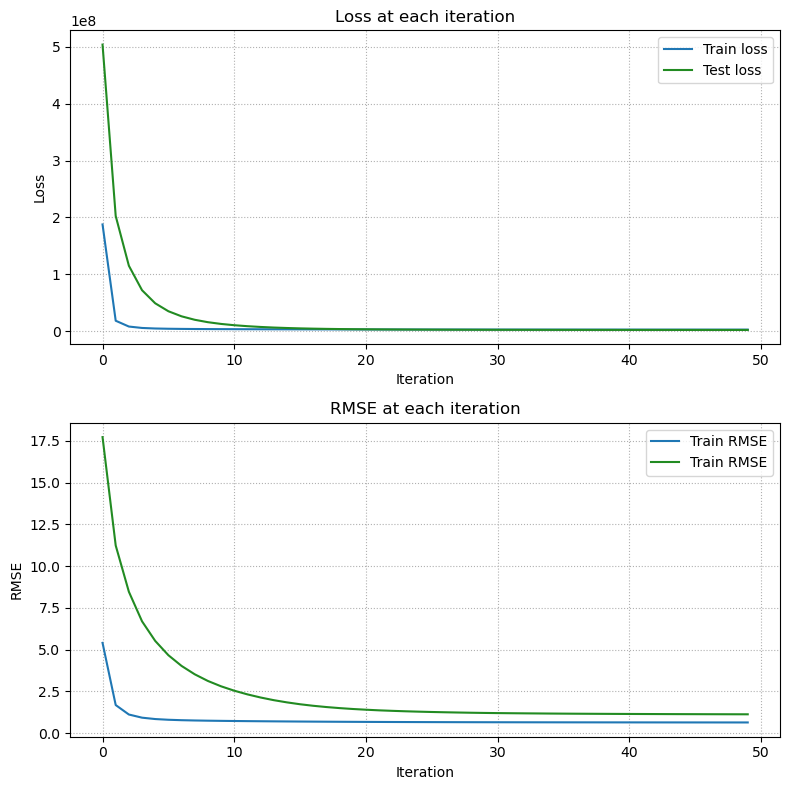

In [19]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

axs[0].plot(train_loss, label="Train loss")
axs[0].plot(test_loss, color="forestgreen", label="Test loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss at each iteration")
axs[0].grid(True, linestyle=":")
axs[0].legend()

axs[1].plot(train_rmse, label="Train RMSE")
axs[1].plot(test_rmse, color="forestgreen", label="Train RMSE")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("RMSE")
axs[1].set_title("RMSE at each iteration")
axs[1].grid(True, linestyle=":")
axs[1].legend()

plt.tight_layout()
plt.savefig("../artifacts/plot/32m_training_with_features_20.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [20]:
save_params(
    "../artifacts/model/32m_users_training_features_20", 
    hyper_params["r_lambda"],
    hyper_params["r_tau"],
    hyper_params["r_gamma"],
    train.idx_to_user_id,
    train.idx_to_movie_id,
    user_bias,
    movie_bias,
    user_embeddings,
    movie_embeddings,
    train.idx_to_feat_id,
    feat_embeddings,
)

---